# 回線切れの数
# 武器の詳細追加
#### cv score :  0.5490586011342156 (5 folds)
#### cv score :  0.551296786389414 (10 folds)

In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import sklearn
from Functions import prepro
import warnings

import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from lightgbm import LGBMClassifier


random.seed(0)

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/spla/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train_df = pd.read_csv("../../data/Processed/train2.csv")
test_df = pd.read_csv("../../data/Processed/test2.csv")
print(train_df.shape)
print(test_df.shape)

(132250, 193)
(28340, 192)


### 武器の情報を個人ごとからチームごとに変える
category1, 2を落とす、

他のカテゴリをチームごとにする

reskinそのまま

In [ ]:
# 落とさないほうが精度上がってしまった。。。

"""suffixes = ["-A1", "-A2", "-A3", "-A4", "-B1", "-B2", "-B3", "-B4"]
drop_cols = ["category1", "category2"]

for c in drop_cols:
    for s in suffixes:
        col = c+s
        train_df.drop(col, axis=1, inplace=True)
        test_df.drop(col, axis=1, inplace=True)
"""

In [3]:
y = train_df["y"]
train_df = train_df.drop("y", axis=1)

In [4]:
# add info about numeric column

num_cols = ["level", "range", "rapid-", "atack"]

#train_df = prepro.flat(train_df, num_cols)
#test_df = prepro.flat(test_df, num_cols)

train_df = prepro.add_numeric_info(train_df, num_cols)
test_df = prepro.add_numeric_info(test_df, num_cols)

In [5]:
# add team info

train_df,  test_df = prepro.addTeamInfo(train_df, test_df, cols=["special", "subweapon", "category1", "category2", "mainweapon"])

(160590, 240)
special-A
special-B
subweapon-A
subweapon-B
category1-A
category1-B
category2-A
category2-B
mainweapon-A
mainweapon-B
(160590, 424)
complete


In [6]:
# add disconnection info

train_df = prepro.add_disconnection(train_df)
test_df = prepro.add_disconnection(test_df)

In [7]:
# categorize team

categorize_col = ["category1", "category2", "subweapon", "special", "mainweapon"]
for col in categorize_col:
    print(col)
    train_df_, test_df_ = prepro.categorize_team(train_df, test_df, col)

category1
category2
subweapon
special
mainweapon


In [9]:
#target encoding

#cat_tgtenc_cols = ["mode", "stage", "team-category1-A", "team-category1-B", 
#                  "team-category2-A", "team-category2-B", "team-subweapon-A", "team-subweapon-B", "team-special-A", "team-special-B"]

cat_tgtenc_cols = ["mode", "stage", "team-category1-A", "team-category1-B"]
for col in cat_tgtenc_cols:
    print(col)
    train_df, test_df = prepro.target_encoding(train_df, test_df, y, col)
    

mode
fold 0
fold 1
fold 2
fold 3
fold 4
stage
fold 0
fold 1
fold 2
fold 3
fold 4
team-category1-A
fold 0
fold 1
fold 2
fold 3
fold 4
team-category1-B
fold 0
fold 1
fold 2
fold 3
fold 4


In [10]:
# make input

# categorical_feature = train_df.dtypes[train_df.dtypes == "object"].index.to_list()

drop_cols = ["id", "lobby", "lobby-mode",  "period", "game-ver", "A1-weapon", "A2-weapon", "A3-weapon", "A4-weapon", \
              "B1-weapon", "B2-weapon", "B3-weapon", "B4-weapon"]

categorical_feature = [col for col in train_df.dtypes[train_df.dtypes == "object"].index.to_list() if col not in drop_cols]
X, test_X = prepro.make_input(train_df, test_df, drop_cols, categorical_encode=True, verbose=False)

X[categorical_feature] = X[categorical_feature].astype("category")

In [24]:
# 全データを5つに分割
SIZE = X.shape[0]
K = 5

folds = prepro.make_kfolds(SIZE, K)
print(len(folds))
for i, fold in enumerate(folds):
    print("fold ", i+1, " size is ", len(fold))
    

    
if SIZE != len(set(sum(folds, []))):
    print("error is occuring in spliting")
else :
    print("successfully split")


5
fold  1  size is  26450
fold  2  size is  26450
fold  3  size is  26450
fold  4  size is  26450
fold  5  size is  26450
successfully split


In [28]:
param = {
    "num_leaves" : 20,
    "n_estimators" : 100,
    "learning_rate" : 0.1,
    "num_iterations" : 1000,
    "objective" : "binary",
    "metric" : ["binary_logloss"],
    "random_state" : 1234,
}

THRESHOLD = 0.50
models = []
cv_scores = []
temp = 0
train_pred = []

all_indices = sum(folds, [])
for i in range(K):
    print("======================== fold {} ========================".format(i))
    valid_indices = folds[i]
    train_indices = list(set(all_indices) - set(valid_indices))
    # print("train ", len(train_indices), " , valid ", len(valid_indices))
    train_X = X.iloc[train_indices].values
    train_y = y.iloc[train_indices].values
    valid_X = X.iloc[valid_indices].values
    valid_y = y.iloc[valid_indices].values
    
    train_data = lgb.Dataset(train_X, label=train_y)
    valid_data = lgb.Dataset(valid_X, label=valid_y)
    
    model = lgb.train(
        param, 
        train_data, 
        valid_sets=valid_data, 
        #categorical_feature=categorical_feature,
        early_stopping_rounds=10, 
        verbose_eval=20,
        
    )
    pred = model.predict(valid_X)
    pred = np.where(pred < THRESHOLD, 0, 1)
    train_pred.append(pred)
    temp += np.sum(pred)
    
    score = accuracy_score(pred, valid_y)
    
    models.append(model)
    cv_scores.append(score)
    
    
print("cv score : ", np.mean(cv_scores))    
print("cv ratio : ", temp / SIZE)

======================== fold 0 ========================
Training until validation scores don't improve for 10 rounds
[20]	valid_0's binary_logloss: 0.6859
[40]	valid_0's binary_logloss: 0.684123
[60]	valid_0's binary_logloss: 0.683291
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.683204
======================== fold 1 ========================
Training until validation scores don't improve for 10 rounds
[20]	valid_0's binary_logloss: 0.686351
[40]	valid_0's binary_logloss: 0.684607
[60]	valid_0's binary_logloss: 0.684106
[80]	valid_0's binary_logloss: 0.684064
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.683957
======================== fold 2 ========================
Training until validation scores don't improve for 10 rounds
[20]	valid_0's binary_logloss: 0.685646
[40]	valid_0's binary_logloss: 0.683886
[60]	valid_0's binary_logloss: 0.683044
[80]	valid_0's binary_logloss: 0.682825
[100]	valid_0's binary_logloss: 0.682706
Early stopping, b

0.5106245618919778
0.512178105409691
0.5125581169301092
0.5092966978743626
0.5101300215448834
0.5109575007302047


array([[<AxesSubplot:title={'center':'pred'}>]], dtype=object)

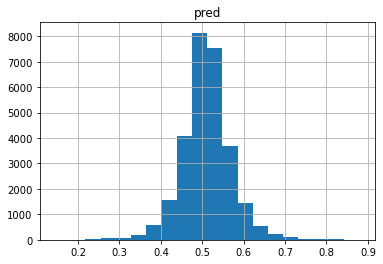

In [21]:
preds = []
for i in range(K):
    model = models[i]
    pred = model.predict(test_X)
    preds.append(pred)
    print(np.sum(pred) / pred.shape[0])
    
preds = np.array(preds)
preds = np.mean(preds, axis=0)
print(np.sum(preds) / preds.shape[0])


temp = pd.DataFrame({"pred":pred})
temp.hist(bins=20)

In [22]:
preds = np.where(preds < THRESHOLD, 0, 1)
print(np.sum(preds) / preds.shape[0])

submit_df = pd.DataFrame({'y': preds})
submit_df.index.name = 'id'
submit_df.to_csv('../Submissions/submission9_{}.csv'.format(K))

0.5896259703599153


# モデル解釈

In [36]:
importance = pd.DataFrame(models[1].feature_importance(), index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
display(importance[:50])

,importance
A-level-median,49
B-level-median,43
team-category1-A-tgt-enc,35
A1-level,34
team-category1-B-tgt-enc,30
A-level-max,29
stage-tgt-enc,28
B-level-sum,27
B-level-max,26
B1-level,24


In [34]:
importance["importance"].sum()

1406

In [ ]:
train_df["pred"] = 0
train_df["y"] = y.values
for i in range(K):
    train_df["pred"].iloc[folds[i]] = train_pred[i]

In [ ]:
result_df = train_df[train_df["y"] != train_df["pred"]]

In [ ]:
print(result_df[result_df["mode"] == "nawabari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "hoko"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "asari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "area"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "yagura"].shape[0]/result_df.shape[0])

In [ ]:
train_df